# Bicycle trajectory forecasting in Bologna

## 2 - Deep Neural Network

The first attempt at trajectory prediction has been made using a Deep Neural Network, and framing the task as a regression (extrapolation) problem.

In [1]:
import pandas as pd
import numpy as np

seed_value = 1789

np.random.seed(seed_value)

We load the data and create the data and "label" sets containing the extrapolated value. For comparison with the subsequent notebooks, we present here the case where only a single point is predicted, but framing the problem as a regression task it is in principle possible to forecast more than a single point.

In [2]:
bd_data = pd.read_csv("../../preproc/may_encoded_bike_bidimensional.csv", header = None).to_numpy()

read = 11
pred = 12 - read

assert pred > 0

X = np.concatenate((bd_data[:,:read], bd_data[:,12:12+read]), axis = 1)
Y = np.concatenate((bd_data[:,read: 12], bd_data[:,12+read:24]), axis = 1)

In [3]:
X[0]

array([-6.49122807, -6.49122807, -6.49122807, -6.14035088, -5.78947368,
       -5.43859649, -5.0877193 , -4.73684211, -4.73684211, -4.38596491,
       -4.03508772, -1.5       , -2.        , -2.5       , -2.5       ,
       -2.5       , -2.5       , -2.        , -2.        , -1.5       ,
       -1.5       , -1.5       ])

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

tf.random.set_seed(seed_value)

# The following line might need to be uncommented depending on the version of keras and tensorflow
#tf.keras.utils.set_random_seed(seed_value)

We define a DNN model with three hidden layers. We choose densely connected layers , ReLU activations and a Glorot initialiser.

Due to the discrete nature of the original data, we choose a Mean Average Error (MAE) loss function.

The present architecture has been chosen after experimenting with different configurations.

In [16]:
model = keras.Sequential()
model.add(layers.Dense( 64, kernel_initializer='glorot_normal', activation='relu', input_shape=(2*read,)))
model.add(layers.Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(layers.Dense( 64, kernel_initializer='glorot_normal', activation='relu'))
model.add(layers.Dense(2*pred))

loss_function = 'mae'
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss_function, optimizer=adam,metrics=['mse'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 18,178
Trainable params: 18,178
Non-trainable params: 0
_________________________________________________________________


Perform a train-test split of the May data. Then fit for 40 epochs.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.70)

In [17]:
history = model.fit(X_train, Y_train, epochs= 40,batch_size=100, validation_data=(X_test, Y_test))

Epoch 1/40
3591/3591 [==============================] - 6s 2ms/step - loss: 0.2923 - mse: 0.2919 - val_loss: 0.2240 - val_mse: 0.0858
Epoch 2/40
3591/3591 [==============================] - 6s 2ms/step - loss: 0.2118 - mse: 0.0748 - val_loss: 0.2049 - val_mse: 0.0707
Epoch 3/40
3591/3591 [==============================] - 6s 2ms/step - loss: 0.2053 - mse: 0.0715 - val_loss: 0.2033 - val_mse: 0.0706
Epoch 4/40
3591/3591 [==============================] - 6s 2ms/step - loss: 0.1997 - mse: 0.0692 - val_loss: 0.1958 - val_mse: 0.0673
Epoch 5/40
3591/3591 [==============================] - 6s 2ms/step - loss: 0.1966 - mse: 0.0680 - val_loss: 0.1955 - val_mse: 0.0683
Epoch 6/40
3591/3591 [==============================] - 6s 2ms/step - loss: 0.1927 - mse: 0.0663 - val_loss: 0.1846 - val_mse: 0.0627
Epoch 7/40
3591/3591 [==============================] - 6s 2ms/step - loss: 0.1891 - mse: 0.0650 - val_loss: 0.1838 - val_mse: 0.0627
Epoch 8/40
3591/3591 [==============================] - 6s 2ms

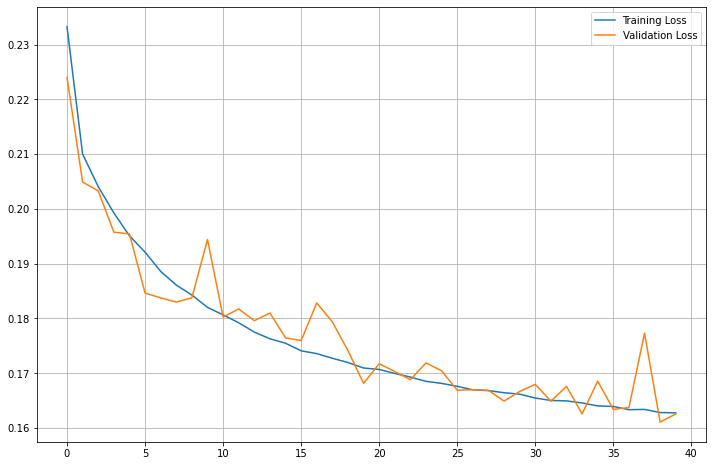

In [18]:
import matplotlib.pyplot as plt

f, a = plt.subplots(figsize=(12,8))

a.plot(history.history['loss'], label = "Training Loss")
a.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.grid(True)

Due to the discrete nature of the original data, it would be best to measure the performance of the algorithm with some kind of accuracy measure.

To this end, we need to map the predicted and true values back to discrete $(i,j)$ coordinates.

In [19]:
p_xy = model.predict(X_test)

In [20]:
t_xy = Y_test

Here we introduce a utility function that maps an array of bidimensional coordinates back to $(i,j)$ pairs, and apply it right-away to the predictions.

In [21]:
def to_ij(arr):
    prepared = arr.reshape(2,-1).T /10
    res = np.array([])
    for it in prepared:
        res = np.append(res, np.round([57/2*(1+it[0]), -20*(it[1]-1) ]))
    return res
p_ijs = np.array([to_ij(p) for p in p_xy])

And analogously we do for the true values.

In [22]:
t_ijs = np.array([to_ij(t) for t in t_xy])

Now we evaluate the accuracy of prediction, with an auxiliary function `eval_acc()` which returns in order
1. The fraction of trajectories for which all predicted points are correct,
2. The fraction of trajectories for which only the first predicted point is correct.

By construction the two values coincide when we predict a single future step.

In [23]:
def eval_acc(p, t, size = pred):
    l_p = p.shape[0]
    l_t = t.shape[0]
    assert l_p == l_t, "Test and prediction size do not match!"
    all_correct   = 0.
    first_correct = 0.
    for r_p, r_t in zip(p,t):
        #print(r_p, r_t)
        if (r_p == r_t).all():
            all_correct += 1
        if (r_p[:2] == r_t[:2]).all():
            first_correct +=1
    return np.array([all_correct, first_correct])/l_p

eval_acc(p_ijs, t_ijs)

array([0.55121698, 0.55121698])

We see that this kind of network can attain an accuracy of $\approx 55 \%$, which is better than the value we would obtain in a random guess within the Moore neighbourhood of each cell, which yields $12.5 \%$.